In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
import sounddevice as sd
import wavio
from keras.models import load_model
import time
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [1]:
warnings.filterwarnings('ignore')

#  labels and paths of voice data
paths = []
labels = []
for dirname, _, filenames in os.walk('./archive1/'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[0]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

# Data frame which contains labels and paths
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

# extracting MFCC features
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

# Extract MFCC features for each voice file in the data frame
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

# Convert the features into an array
X = [x for x in X_mfcc]
X = np.array(X)

# Reshape input data to make it suitable for the LSTM model
X = np.expand_dims(X, -1)

# Convert the labels to One-Hot encoding
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])
y = y.toarray()

# Create the LSTM model
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Trainig model
history = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64)
model.save('EmotionModel.h5')

Dataset is Loaded



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None,

In [9]:
from sklearn.model_selection import train_test_split

# Eğitim ve test veri setini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Test verisi üzerinde modeli değerlendirme
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


2/2 [==============================] - 0s 9ms/step - loss: 1.1876 - accuracy: 0.6042
Test Loss: 1.187552809715271
Test Accuracy: 0.6041666865348816


2/2 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.50      0.54      0.52        13
           1       0.58      1.00      0.73        11
           2       0.71      0.83      0.77        12
           3       1.00      0.08      0.15        12

    accuracy                           0.60        48
   macro avg       0.70      0.61      0.54        48
weighted avg       0.70      0.60      0.54        48

[[ 7  3  3  0]
 [ 0 11  0  0]
 [ 2  0 10  0]
 [ 5  5  1  1]]


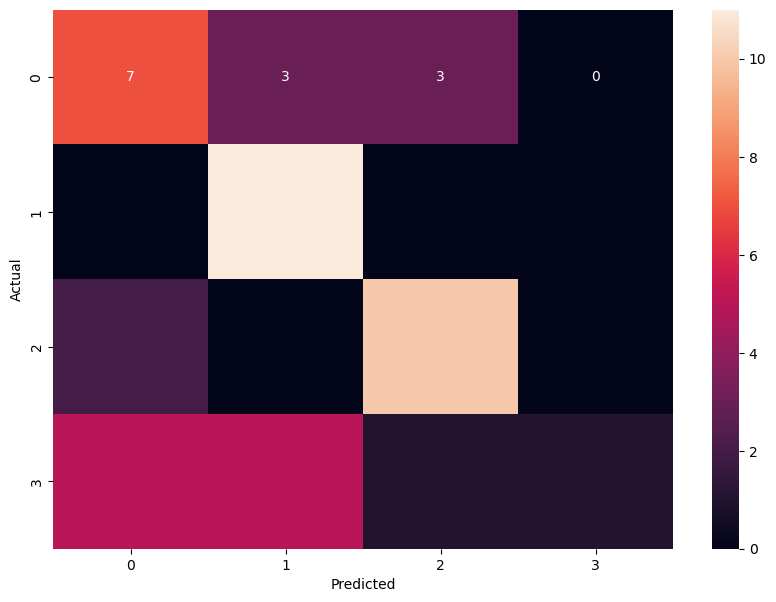

In [10]:
# Prediction
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# classification report
print(classification_report(y_true, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [7]:
# Load model
model = load_model('EmotionModel.h5')

# Vocie record 3 second period
def record_audio(duration=3, fs=16000):
    print("Recording started...")
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
    sd.wait()  # Wait until the recording is complete
    print("Recording finished.")
    wavio.write("test.wav", recording, fs, sampwidth=2)  #  The recorded audio is written to the "test.wav" file
    return "test.wav"

#Extract MFCC features from the recorded audio
def extract_mfcc_from_file(file_path):
    y, sr = librosa.load(file_path, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

# Real time prediction
def predict_emotion():
    # 3 second voice record
    file_path = record_audio()

    # Extract MFCC features
    mfcc = extract_mfcc_from_file(file_path)
    mfcc = np.expand_dims(mfcc, axis=0)  # Reshape to fit the model
    mfcc = np.expand_dims(mfcc, axis=-1)

    # Make prediction
    prediction = model.predict(mfcc)
    predicted_label = np.argmax(prediction, axis=1)

    # Decode the labels
    labels = enc.categories_[0]
    print(f"Predicted Emotion: {labels[predicted_label[0]]}")

# Loop for continuous predictions
try:
    while True:
        predict_emotion()
        time.sleep(1)  # Wait 1 second after each recording
except KeyboardInterrupt:
    print("Real-time prediction stopped.")


Recording started...
Recording finished.
1/1 [==============================] - 1s 583ms/step
Predicted Emotion: sad
Recording started...
Recording finished.
1/1 [==============================] - 0s 38ms/step
Predicted Emotion: happy
Recording started...
Real-time prediction stopped.
